# Multi-slice ptychography figure

> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the multi-slice ptychography figure (Fig. 12) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from emdfile import tqdmnd
from abtem.noise import poisson_noise

## abTEM Simulation

In [2]:
def abtem_atomic_model(num_cells):

    STO_unit_cell = ase.io.read("data/SrTiO3.cif")
    STO_atoms = ase.build.surface(STO_unit_cell, (1, 1, 0), 4, periodic=True) * (2, 3, 1)
    STO_atoms_thick = STO_atoms * (5,5,num_cells)
    STO_atoms_thick.rotate(20, 'z')
    STO_atoms_thick.translate((15,25,0))
    STO_atoms_thick.center(axis=(0,1))
    STO_atoms_thick.translate((-15,-25,0))
    del STO_atoms_thick[STO_atoms_thick.positions[:,0]<0]
    del STO_atoms_thick[STO_atoms_thick.positions[:,1]<0]

    STO_atoms_thick.cell[0,0]=50
    STO_atoms_thick.cell[1,1]=50
    
    return STO_atoms_thick

def abtem_simulate(num_cells):
    
    #build structure
    STO_atoms_thick = abtem_atomic_model(num_cells)

    frozen_phonons = abtem.temperature.FrozenPhonons(STO_atoms_thick, 12, 0.1)
    potential_thick = abtem.Potential(
        #frozen_phonons, # uncomment this for a realistic simulation
        STO_atoms_thick, # comment this for a realistic simulation
        sampling=0.1,
        device="gpu",
        projection="infinite",
        parametrization="kirkland",
    )
    
    probe = abtem.Probe(semiangle_cutoff=20, energy=200e3, defocus=100,device="gpu")
    probe.match_grid(potential_thick)

    pixelated_detector = abtem.PixelatedDetector(max_angle=None)
    gridscan = abtem.GridScan(
        (15, 15), 
        (40, 45), 
        sampling=0.5,
        endpoint=True
    )
    measurement_thick = probe.scan(gridscan, pixelated_detector, potential_thick,pbar=True)
        
    return measurement_thick, measurement_thick.calibrations[-1].sampling, gridscan.sampling

def return_noisy_array(num_cells, bin_factor, electrons_per_area):
    measurement, angular_sampling, gridscan_sampling = abtem_simulate(num_cells)
    sx,sy,qx,qy = measurement.shape
    qx = (qx-260)//bin_factor
    qy = (qy-260)//bin_factor
    
    array = np.zeros((sx,sy,qx,qy))
    for ix, iy in tqdmnd(sx,sy,disable=True):
        array[ix,iy] = measurement.array[ix,iy,130:-130,130:-130].reshape((qx,bin_factor,qy,bin_factor)).sum((1,3))

    electrons_per_probe = electrons_per_area*np.array(gridscan_sampling).prod()
    noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)

    return noisy_array, angular_sampling*bin_factor, gridscan_sampling[0]

In [3]:
noisy_array_8, angular_sampling, gridscan_sampling = return_noisy_array(8,2,1e4)
noisy_array_16, _, _ = return_noisy_array(16,2,1e4)
noisy_array_24, _, _ = return_noisy_array(24,2,1e4)

Potential:   0%|          | 0/179 [00:00<?, ?it/s]

Scan:   0%|          | 0/3111 [00:00<?, ?it/s]

Potential:   0%|          | 0/358 [00:00<?, ?it/s]

Scan:   0%|          | 0/3111 [00:00<?, ?it/s]

Potential:   0%|          | 0/536 [00:00<?, ?it/s]

Scan:   0%|          | 0/3111 [00:00<?, ?it/s]

In [4]:
dc_24 = py4DSTEM.DataCube(data = noisy_array_24)
dc_24.calibration.set_R_pixel_size(gridscan_sampling)
dc_24.calibration.set_R_pixel_units('A')
dc_24.calibration.set_Q_pixel_size(angular_sampling)
dc_24.calibration.set_Q_pixel_units('mrad')

dc_16 = py4DSTEM.DataCube(data = noisy_array_16)
dc_16.calibration.set_R_pixel_size(gridscan_sampling)
dc_16.calibration.set_R_pixel_units('A')
dc_16.calibration.set_Q_pixel_size(angular_sampling)
dc_16.calibration.set_Q_pixel_units('mrad')

dc_8 = py4DSTEM.DataCube(data = noisy_array_8)
dc_8.calibration.set_R_pixel_size(gridscan_sampling)
dc_8.calibration.set_R_pixel_units('A')
dc_8.calibration.set_Q_pixel_size(angular_sampling)
dc_8.calibration.set_Q_pixel_units('mrad')
dc_8.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1.0031736126931385
             R_pixel_size:    0.5
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

In [7]:
# py4DSTEM.save("ms-figure_STO-8x4-layers.h5",dc_8,mode='o')
# py4DSTEM.save("ms-figure_STO-16x4-layers.h5",dc_16,mode='o')
# py4DSTEM.save("ms-figure_STO-24x4-layers.h5",dc_24,mode='o')

In [5]:
# dc_8=py4DSTEM.read("ms-figure_STO-8x4-layers.h5")
# dc_16=py4DSTEM.read("ms-figure_STO-16x4-layers.h5")
# dc_24=py4DSTEM.read("ms-figure_STO-24x4-layers.h5")

dc_8_binned = dc_8.copy().bin_Q(2)
dc_16_binned = dc_16.copy().bin_Q(2)
dc_24_binned = dc_24.copy().bin_Q(2)

## Multislice ptychography

In [6]:
slice_thicknesses = abtem_atomic_model(1).cell[2,2]

ptycho_8 = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dc_8,
    verbose=False,
    energy=200e3,
    num_slices=8,
    slice_thicknesses=slice_thicknesses,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    seed_random=0,
    num_iter = 128,
    identical_slices=True,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [01:45<00:00,  1.22 iter/s]


In [7]:
ptycho_8_binned = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dc_8_binned,
    verbose=False,
    energy=200e3,
    num_slices=8,
    slice_thicknesses=slice_thicknesses,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    seed_random=0,
    num_iter = 128,
    identical_slices=True,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [01:02<00:00,  2.04 iter/s]


In [8]:
ptycho_16 = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dc_16,
    verbose=False,
    energy=200e3,
    num_slices=16,
    slice_thicknesses=slice_thicknesses,
    semiangle_cutoff=20,
    defocus=100,
    device='gpu',
    storage='cpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    identical_slices=True,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [03:19<00:00,  1.56s/ iter]


In [9]:
ptycho_16_binned = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dc_16_binned,
    verbose=False,
    energy=200e3,
    num_slices=16,
    slice_thicknesses=slice_thicknesses,
    semiangle_cutoff=20,
    defocus=100,
    device='gpu',
    storage='cpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    identical_slices=True,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [01:59<00:00,  1.07 iter/s]


In [10]:
ptycho_24 = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dc_24,
    verbose=False,
    energy=200e3,
    num_slices=24,
    slice_thicknesses=slice_thicknesses,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    identical_slices=True,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [04:54<00:00,  2.30s/ iter]


In [11]:
ptycho_24_binned = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dc_24_binned,
    verbose=False,
    energy=200e3,
    num_slices=24,
    slice_thicknesses=slice_thicknesses,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    identical_slices=True,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [02:59<00:00,  1.41s/ iter]


## Single-slice ptychography

In [12]:
ptycho_8_single_slice = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dc_8,
    verbose=False,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [00:21<00:00,  5.83 iter/s]


In [13]:
ptycho_16_single_slice = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dc_16,
    verbose=False,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [00:21<00:00,  5.84 iter/s]


In [14]:
ptycho_24_single_slice = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dc_24,
    verbose=False,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    storage='cpu',
    device='gpu',
    object_padding_px=(12,12),
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps = False,
).reconstruct(
    num_iter = 128,
    step_size=0.125,
    max_batch_size=183, # 61*51 = 183*17
)

Reconstructing object and probe: 100%|███████████████████████████████| 128/128 [00:21<00:00,  5.84 iter/s]


## Visualization

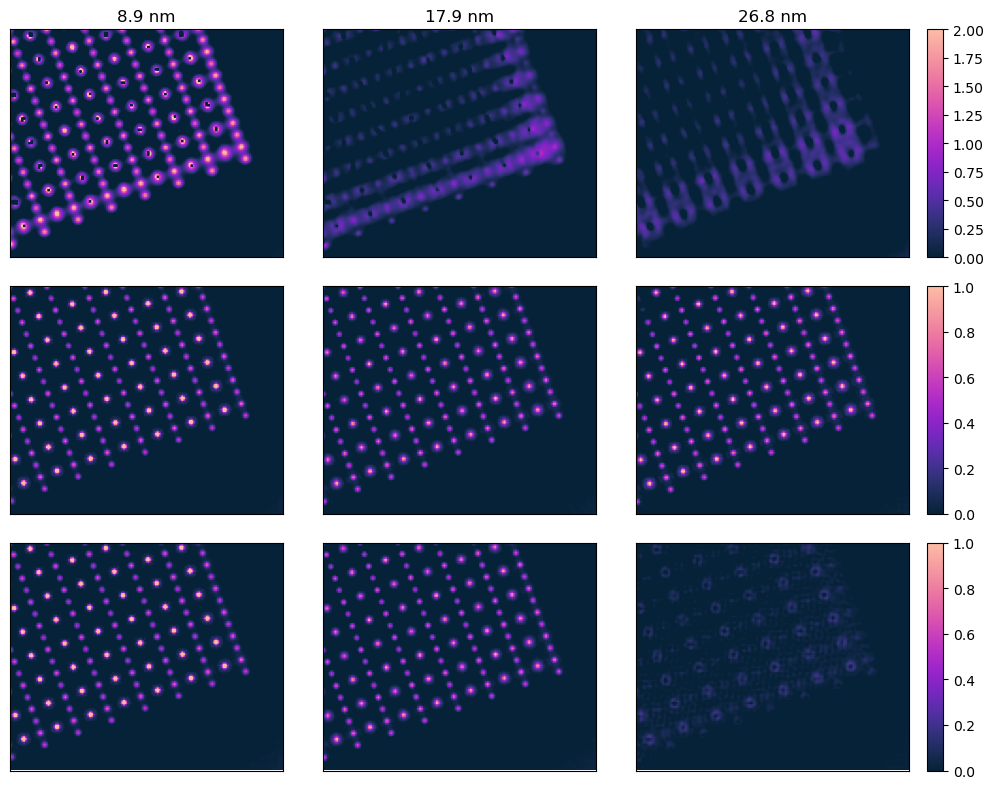

In [15]:
from matplotlib import colors as mcolors, colorbar as mcbar
from matplotlib.gridspec import GridSpec

import cmasher as cmr
cmap = cmr.bubblegum

vmin_ss = 0
vmax_ss = 2
vmin_ms = 0
vmax_ms = 1

fig = plt.figure(figsize=(10.25,8))
spec = GridSpec(
    figure=fig,
    ncols=4,
    nrows=3,
    width_ratios=[20,20,20,1],
    wspace=0.,
    hspace=0.,
)
axs = spec.subplots()
py4DSTEM.show(
    [
        np.angle(ptycho_8_single_slice.object_cropped),
        np.angle(ptycho_16_single_slice.object_cropped),
        np.angle(ptycho_24_single_slice.object_cropped),
    ],
    cmap=cmap,
    vmin=vmin_ss,
    vmax=vmax_ss,
    intensity_range = "absolute",
    axsize=(3,3),
    title=[f"{slice_thicknesses*t/10:.1f} nm" for t in [8,16,24]],
    ticks=False,
    figax=(fig,axs[0,:3])
)


py4DSTEM.show(
    [
        np.angle(ptycho_8.object_cropped).mean(0),
        np.angle(ptycho_16.object_cropped).mean(0),
        np.angle(ptycho_24.object_cropped).mean(0),
    ],
    cmap=cmap,
    vmin=vmin_ms,
    vmax=vmax_ms,
    intensity_range = "absolute",
    axsize=(3,3),
    ticks=False,
    figax=(fig,axs[1,:3])
)

py4DSTEM.show(
    [
        np.angle(ptycho_8_binned.object_cropped).mean(0),
        np.angle(ptycho_16_binned.object_cropped).mean(0),
        np.angle(ptycho_24_binned.object_cropped).mean(0),
    ],
    cmap=cmap,
    vmin=vmin_ms,
    vmax=vmax_ms,
    intensity_range = "absolute",
    axsize=(3,3),
    ticks=False,
    figax=(fig,axs[2,:3])
)

norm_ss = mcolors.Normalize(vmin=vmin_ss,vmax=vmax_ss)
cb_ss = mcbar.ColorbarBase(axs[0,3],cmap=cmap,norm=norm_ss)

norm_ms = mcolors.Normalize(vmin=vmin_ms,vmax=vmax_ms)
cb_ms = mcbar.ColorbarBase(axs[1,3],cmap=cmap,norm=norm_ms)

norm_ms = mcolors.Normalize(vmin=vmin_ms,vmax=vmax_ms)
cb_ms = mcbar.ColorbarBase(axs[2,3],cmap=cmap,norm=norm_ms)

spec.tight_layout(fig)

## Propagated probe

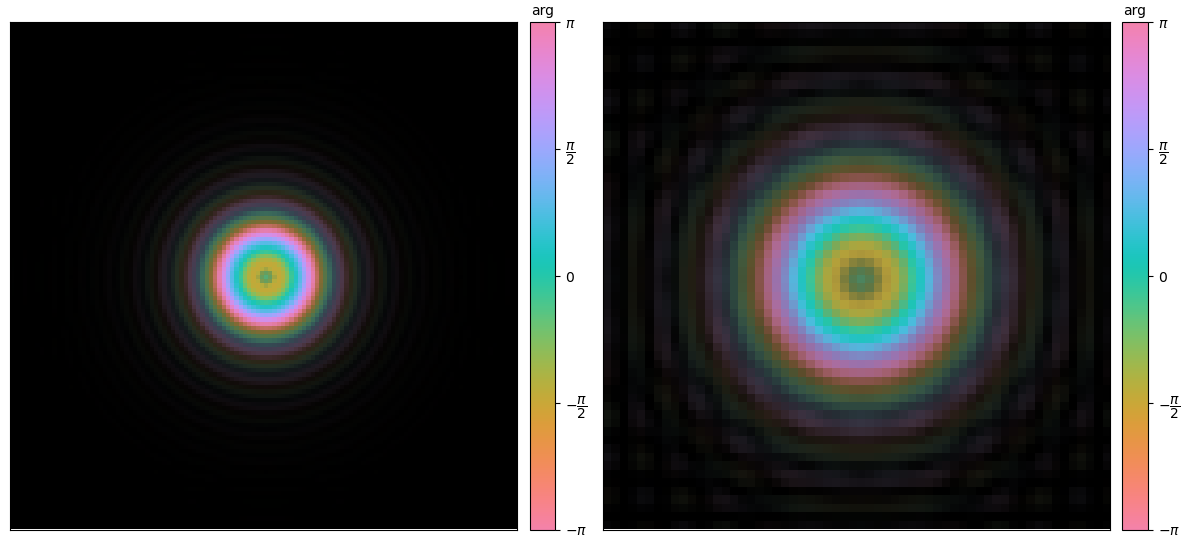

In [16]:
def return_propagated_probe_xz(ptycho):
    """ return propagated probe file along the xz plane """
    xp = ptycho._xp
    asnumpy = ptycho._asnumpy
    zoom = ptycho._scipy.ndimage.zoom
    
    propagator_arrays = ptycho._propagator_arrays
    propagated_probes = xp.empty(
        (
            ptycho._num_slices,
            ptycho._region_of_interest_shape[0],
            ptycho._region_of_interest_shape[1]
        ),
        dtype=xp.complex64
    )
    propagated_probes[0] =ptycho._probe_initial
    
    for s in range(1,ptycho._num_slices):
        propagated_probes[s] = ptycho._propagate_array(
            propagated_probes[s-1], propagator_arrays[s-1]
        )
    
    propagated_probes = xp.fft.fftshift(propagated_probes,axes=(-2,-1))
    propagated_probes_summed = asnumpy(zoom(propagated_probes.sum(2),(8,1),order=1))
    return asnumpy(propagated_probes), propagated_probes_summed

propagated_probes_24, propagated_probes_summed_24 = return_propagated_probe_xz(ptycho_24)
propagated_probes_24_binned, propagated_probes_summed_24_binned = return_propagated_probe_xz(ptycho_24_binned)

probe_fig,probe_ax = py4DSTEM.show_complex(
    [
        propagated_probes_24[-1],
        propagated_probes_24_binned[-1]
    ],
    ticks=False,
    returnfig=True,
)

#probe_fig.savefig("multislice-probe-figure_20240423.pdf",bbox_inches="tight")

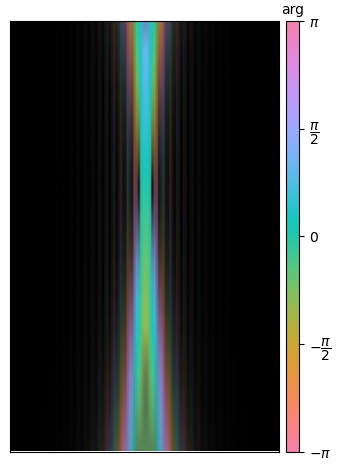

In [17]:
py4DSTEM.show_complex(
    propagated_probes_summed_24,
    ticks=False,
)

## Postprocessing
> Done in Inkscape